In [2]:
import torch
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm

random.seed(42)

In [3]:
data_dir = '../osic-pulmonary-fibrosis-progression'

In [4]:
from preprocess import preprocess_scans
import pickle

if not os.path.exists(f'{data_dir}/preprocessed_scans.pkl'):
    preprocessed_scans = preprocess_scans(data_dir)
    pickle.dump(preprocessed_scans, open(f'{data_dir}/preprocessed_scans.pkl', 'wb'))

Using device: cuda


In [5]:
# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [6]:
# Prepare train and val data
train_datas = pd.read_csv(data_dir + '/train.csv')
test_datas = pd.read_csv(data_dir + '/test.csv')

# Remove row in train data if patient_id is in test_patient_ids
train_datas = train_datas[~train_datas['Patient'].isin(test_datas)]

# Sort df by patient and then by 'Weeks'
train_datas = train_datas.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value and weeks
patient_id_to_initial_FVC = train_datas.groupby('Patient')['FVC'].first().to_dict()
patient_id_to_initial_weeks = train_datas.groupby('Patient')['Weeks'].first().to_dict()

train_datas, val_datas = train_val_split(train_datas)

# Count the number of scans for each patient
scan_count = {}
for patient_id in os.listdir(os.path.join(data_dir, 'train')):
    scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'train', patient_id)))


In [7]:
from collections import defaultdict

train_x, train_y = defaultdict(list), defaultdict(list)

for idx, row in train_datas.iterrows():
    train_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    train_y[row['Patient']].append(row['FVC'])

val_x, val_y = defaultdict(list), defaultdict(list)

for idx, row in val_datas.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC'])

In [8]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.conv1(scans))
        x = self.pool(x) # num_slices, 32, 128, 128
    
        x = F.relu(self.conv2(x))
        x = self.pool(x) # num_slices, 64, 64, 64
        
        x = F.relu(self.conv3(x))
        x = self.pool(x) # num_slices, 128, 32, 32

        x = F.relu(self.conv4(x))
        x = self.pool(x) # num_slices, 256, 16, 16

        x = F.relu(self.conv5(x))
        x = self.pool(x) # num_slices, 512, 8, 8

        # x = self.global_pool(x) # num_slices, 512, 1, 1

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512*8*8+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.conv1(scans))
        x = nn.MaxPool2d(2, 2)(x) # num_slices, 64, 128, 128

        x = self.conv2(x) # num_slices, 64, 64, 64
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.001):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), lr=learning_rate
    )

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")

    for epoch in range(epoch):
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")
        cnn_model.train()
        fc_model.train()

        patient_count = 0
        accum_loss = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            if patient_count % 8 == 0:
                optimizer.zero_grad()
                accum_loss = 0

            patient_scan_count = scan_count[patient_id]
            features = torch.tensor([], dtype=torch.float32, device=device)
            for i in range(1, patient_scan_count + 1, batch_size):
                scans = []
                for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                    scan = get_preprocessed_scan(data_dir, patient_id, j)
                    if scan is None:
                        continue
                scan = torch.tensor(scan, dtype=torch.float32, device=device)
                scans.append(scan)
                scans = torch.stack(scans)
            
                batch_scans = scans
                features = torch.cat([features, cnn_model.forward(batch_scans)])
            
            features = torch.mean(features, dim=0) # 1024,
            
            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate for all datapoints of patient
            for i in range(len(x)):
                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))

                # accumulate gradient
                loss.backward(retain_graph=True)
                accum_loss += loss.item()

            # Update parameters based on batch of 8 patients
            if patient_count % 8 == 7:
                optimizer.step()
            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {accum_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(accum_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in tqdm(val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                features = torch.tensor([], dtype=torch.float32, device=device)
                for i in range(1, patient_scan_count + 1, batch_size):
                    scans = []
                    for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                        scan = get_preprocessed_scan(data_dir, patient_id, j)
                        if scan is None:
                            continue
                    scan = torch.tensor(scan, dtype=torch.float32, device=device)
                    scans.append(scan)
                    scans = torch.stack(scans)
                
                    batch_scans = scans
                    features = torch.cat([features, cnn_model.forward(batch_scans)])
                
                features = torch.mean(features, dim=0) # 1024,
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()
    return training_loss, val_loss

In [11]:
import matplotlib.pyplot as plt
import math

def plot_loss(training_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(training_loss)), [math.log(x) for x in training_loss], label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(val_loss)), [math.log(x) for x in val_loss], label='Validation Loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 36/36 [00:01<00:00, 21.63it/s]


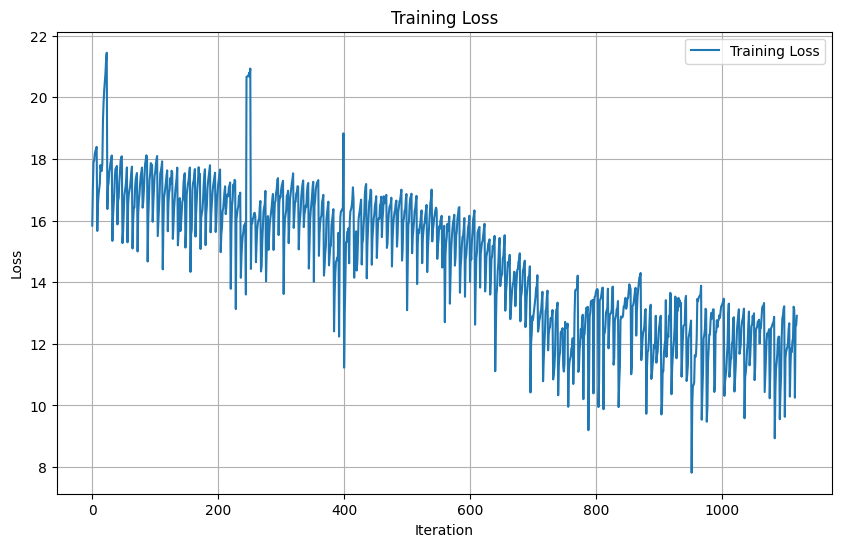

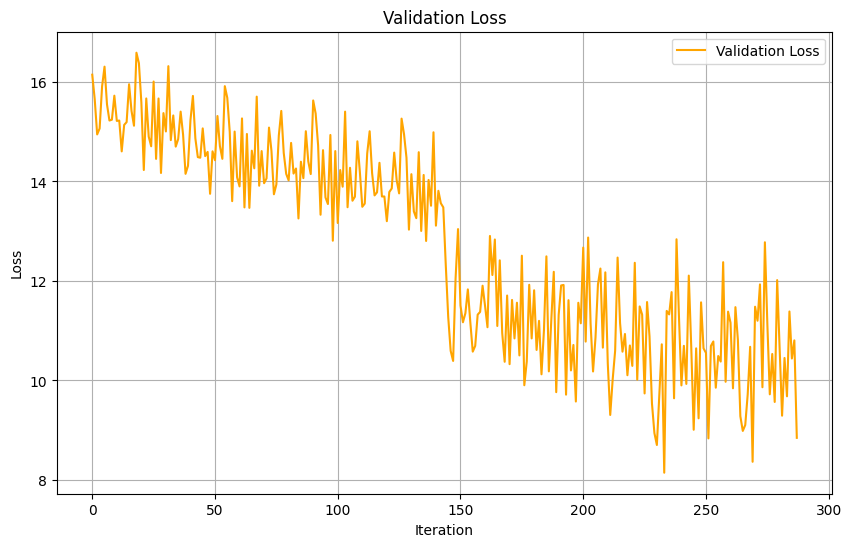

In [12]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_seqblkcnn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8)
plot_loss(training_loss, val_loss)

In [13]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_model, fc_model):
    cnn_model.to(device)
    fc_model.to(device)

    cnn_model.eval()
    fc_model.eval()

    test_datas = pd.read_csv(data_dir + '/test.csv')

    test_x = defaultdict(list)
    test_y = defaultdict(list)

    for idx, row in test_datas.iterrows():
        test_x[row['Patient']].append({
            'Weeks': row['Weeks'],
            'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
            'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
        })
    test_y = defaultdict(list)
    for idx, row in test_datas.iterrows():
        test_y[row['Patient']].append(row['FVC'])

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_x.keys()):
        patient_scan_count = scan_count[patient_id]
        features = torch.tensor([], dtype=torch.float32, device=device)
        for i in range(1, patient_scan_count + 1, batch_size):
            scans = []
            for j in range(i, min(i+batch_size, patient_scan_count + 1)):
                scan = get_test_preprocessed_scan(data_dir, patient_id, j)
                if scan is None:
                    continue
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
            scans.append(scan)
            scans = torch.stack(scans)

            batch_scans = scans
            features = torch.cat([features, cnn_model.forward(batch_scans)])

        features = torch.mean(features, dim=0) # 1024,

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

In [14]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
test_prediction, test_target, loss(test_prediction, test_target)


100%|██████████| 5/5 [00:00<00:00, 18.27it/s]


(tensor([2868.2075, 2629.5212, 1859.7052, 3174.9724, 2799.9944]),
 tensor([3020, 2739, 1930, 3294, 2925]),
 tensor(13952.3770))

In [19]:
class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Follow Imagenet architecture (34 layers)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 6

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        ) + nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 11

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 5

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 2

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

100%|██████████| 36/36 [00:01<00:00, 21.39it/s]


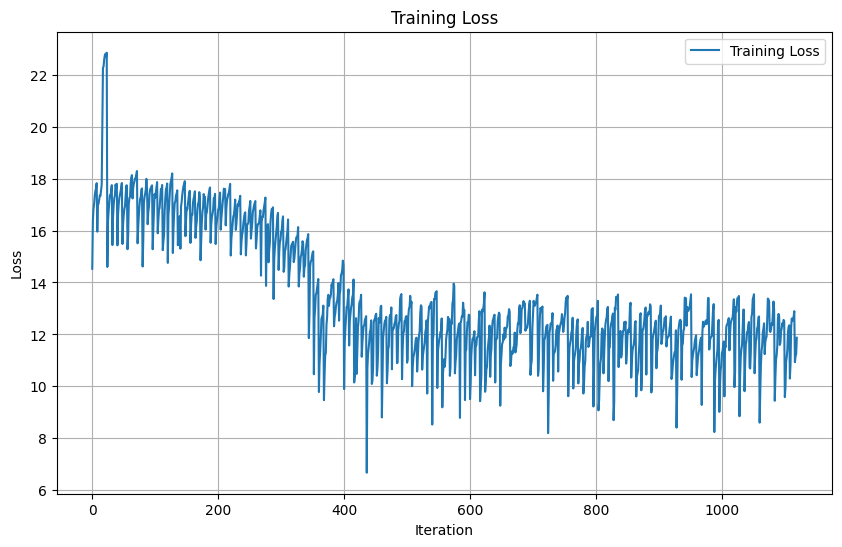

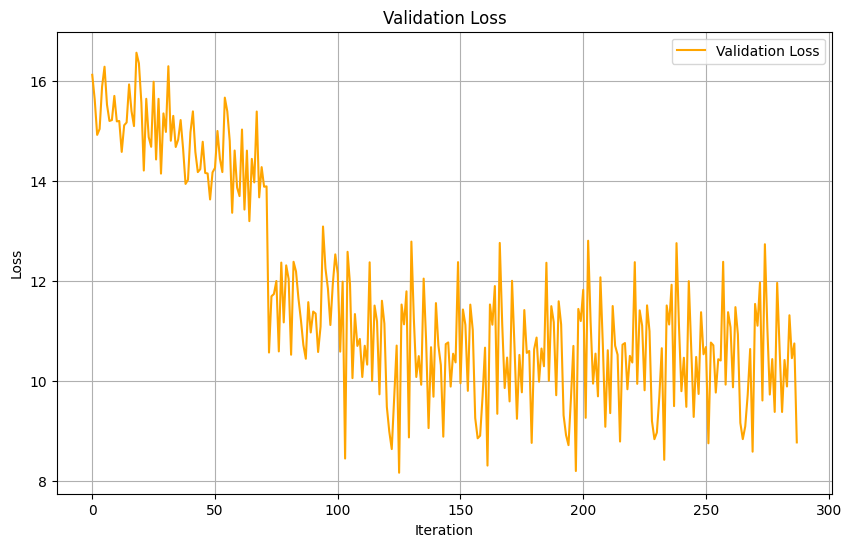

In [20]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_imagenet.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8)
plot_loss(training_loss, val_loss)


In [21]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
test_prediction, test_target, loss(test_prediction, test_target)

100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


(tensor([2885.9556, 2632.1016, 1866.3046, 3153.2839, 2791.0830]),
 tensor([3020, 2739, 1930, 3294, 2925]),
 tensor(14237.4141))

In [ ]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        print(f'before input_conv: {x.shape}')
        x = F.relu(self.input_conv(x))
        print(f'after input_conv: {x.shape}')
        x = self.second_conv(x)
        print(f'after second_conv: {x.shape}')
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 6)
        self.conv3 = self._make_layer(64, 128, 2, 12)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for layer_stride in strides:
            blk = ResidualBlock(input_dim, output_dim, layer_stride)
            layers.append(blk)
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        print(scans.shape)
        x = self.conv1(scans) # num_slices, 64, 63, 63
        print(x.shape)
        x = self.conv2(x) # num_slices, 64, 63, 63
        print(x.shape)
        x = self.conv3(x) # num_slices, 128, 32, 32
        print(x.shape)
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(1, 256)

        return x

In [42]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8)
plot_loss(training_loss, val_loss)

  0%|          | 0/140 [00:00<?, ?it/s]

torch.Size([1, 1, 256, 256])
torch.Size([1, 64, 63, 63])
torch.Size([1, 64, 63, 63])


RuntimeError: Given groups=1, weight of size [128, 64, 3, 3], expected input[1, 128, 32, 32] to have 64 channels, but got 128 channels instead

In [23]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
test_prediction, test_target, loss(test_prediction, test_target)

100%|██████████| 5/5 [00:00<00:00, 16.51it/s]


(tensor([2893.9668, 2636.5430, 1852.9082, 3169.0588, 2795.9263]),
 tensor([3020, 2739, 1930, 3294, 2925]),
 tensor(12919.0547))

In [32]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, initial_stride=2):
        super(ResidualBlock, self).__init__()
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1, stride=initial_stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        residual = x

        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.bn2(self.second_conv(x))
        x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )
        
        self.conv2 = self._make_layer(64, 64, 1, 6)
        self.conv3 = self._make_layer(64, 128, 2, 12)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for layer_stride in strides:
            blk = ResidualBlock(input_dim, output_dim, layer_stride)
            layers.append(blk)
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        print(x)
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(1, 256)

        return x

In [31]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_bn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8)
plot_loss(training_loss, val_loss)

  0%|          | 0/140 [00:00<?, ?it/s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          ...,
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465]],

         [[0.2843, 0.2843, 0.2843,  ..., 0.2843, 0.2843, 0.2843],
          [0.2843, 0.2843, 0.2843,  ..., 0.2843, 0.2843, 0.2843],
          [0.2843, 0.2843, 0.2843,  ..., 0

RuntimeError: The size of tensor a (59) must match the size of tensor b (63) at non-singleton dimension 3